# Forest Fire Detection using Vision Transformers

## 1. Importing necessary libraries

In [ ]:
%%capture

! pip install transformers pytorch-lightning --quiet

import math
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from pathlib import Path
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from torchvision import transforms as transforms
from transformers import ViTFeatureExtractor, ViTForImageClassification
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from random import shuffle

## 2. Spliting the dataset into Train, Validation and Test data

In [7]:
data_dir = Path('data')

In [8]:
ds = ImageFolder(data_dir)
indices = torch.randperm(len(ds)).tolist()
n_val = math.floor(len(indices) * .30)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])
test_ds = ImageFolder('Test_Data')

In [9]:
len(ds.imgs)

4000

## 3. Sample images from the dataset

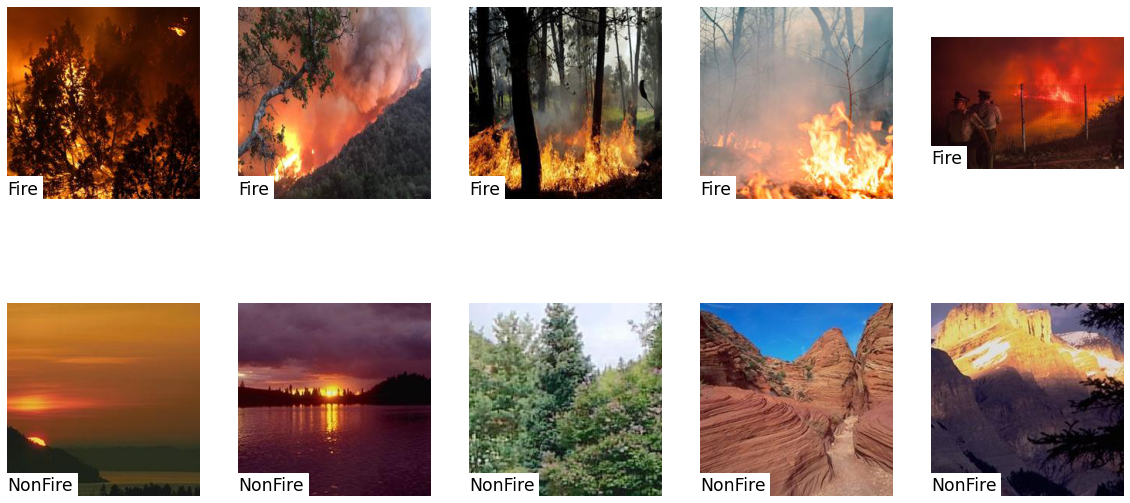

In [ ]:
plt.figure(figsize=(20,10))
num_examples_per_class = 5
i = 1
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    for image_idx, image_path in enumerate(sorted(folder.glob('*'))):
        if image_path.suffix in ds.extensions:
            image = Image.open(image_path)
            plt.subplot(len(ds.classes), num_examples_per_class, i)
            ax = plt.gca()
            ax.set_title(
                class_name,
                size='xx-large',
                pad=5,
                loc='left',
                y=0,
                backgroundcolor='white'
            )
            ax.axis('off')
            plt.imshow(image)
            i += 1

            if image_idx + 1 == num_examples_per_class:
                break

## 4. Creating dictionaries for Labels and IDs

In [10]:
label2id = {}
id2label = {}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

In [11]:
id2label

{'0': 'Fire', '1': 'NonFire'}

In [12]:
label2id

{'Fire': '0', 'NonFire': '1'}

## 5. Downloading Google's Pretrained Vision Transformer and Feature Extractor

In [8]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor
 
    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings 

In [10]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)

## 6. Creating Dataloaders for both train and validation data

In [ ]:
collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=32, collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, collate_fn=collator, num_workers=2)

## 7. Fine tuning the pre-trained model

In [ ]:
class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = Accuracy()
        self.train_acc = Accuracy()

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        t_acc = self.train_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"train_acc", t_acc, prog_bar=True, on_step=True)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"val_loss", outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"val_acc", acc, prog_bar=True)
        return outputs.loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

## 8. Training the model with custom dataset

In [ ]:
pl.seed_everything(24)
classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(gpus=1, precision=16, max_epochs=3)
history = trainer.fit(classifier, train_loader, val_loader)

INFO:pytorch_lightning.utilities.seed:Global seed set to 24
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
trainer.validate(val_loader)

## 9. Saving the trained model locally

In [ ]:
torch.save(model,'/content/drive/MyDrive/main/Models/new_model.pth')

## 10. Loading the model from disk and Evaluating the model

In [1]:
model_path = Path('Models/new_model.pth')
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

NameError: name 'Path' is not defined

In [4]:
model = torch.load(model_path)

In [ ]:
model.eval()

In [13]:
id2label

{'0': 'Fire', '1': 'NonFire'}

In [14]:
ds = ImageFolder('Test_Data')

def prediction_test(img):
  image = Image.open(img)
  try:
    inputs = feature_extractor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_idx = logits.softmax(1).argmax(-1).item()
    return predicted_class_idx
  except:
    print(img)

def test(data):
  predicted = []
  for i in range(len(data)):
    x = prediction_test(data[i][0])
    predicted.append(x)
    if i % 100 == 0:
      print(f'Tested {i} images.')
  return predicted

In [15]:
data = ds.imgs

In [16]:
true_labels = np.array(ds.targets)
predicted_labels = np.array(test(data))

Tested 0 images.
Tested 100 images.
Tested 200 images.
Tested 300 images.
Tested 400 images.
Tested 500 images.
Tested 600 images.
Tested 700 images.
Tested 800 images.
Tested 900 images.
Tested 1000 images.


In [17]:
true_labels

array([0, 0, 0, ..., 1, 1, 1])

In [18]:
predicted_labels

array([0, 0, 0, ..., 1, 1, 1])

In [19]:
len(predicted_labels)

1100

In [20]:
df = pd.DataFrame(confusion_matrix(true_labels, predicted_labels), index=['Actual Fire','Actual Non Fire'], columns=['Predicted Fire','Predicted Non Fire'])

### Confusion Matrix

In [21]:
df

Predicted Fire  Predicted Non Fire
Actual Fire                 546                   4
Actual Non Fire              21                 529

### Classification Report

In [22]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       550
           1       0.99      0.96      0.98       550

    accuracy                           0.98      1100
   macro avg       0.98      0.98      0.98      1100
weighted avg       0.98      0.98      0.98      1100



## 11. Displaying the results

In [25]:
def show_output(image):
  image = image.resize((600,400))
  display(image)

  inputs = feature_extractor(images=image, return_tensors="pt")
  outputs = model(**inputs)
  logits = outputs.logits
  predicted_class_idx = logits.softmax(1).argmax(-1).item()

  #print(id2label[str(predicted_class_idx)])

  if predicted_class_idx == 1:
    print('\n\nNo Fire Detected')
  else:
    print('\n\nFIRE DETECTED !')

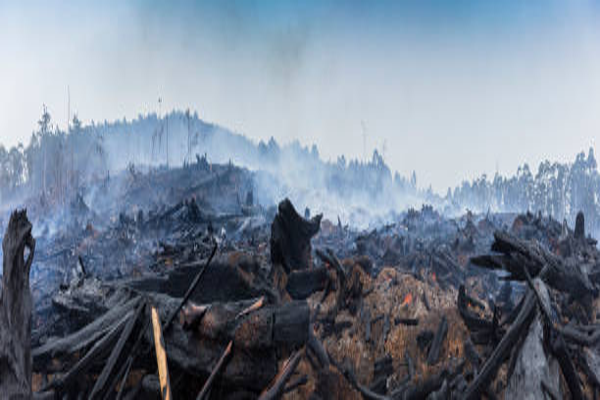



FIRE DETECTED !


In [26]:
image = Image.open('test.jpg')
show_output(image)

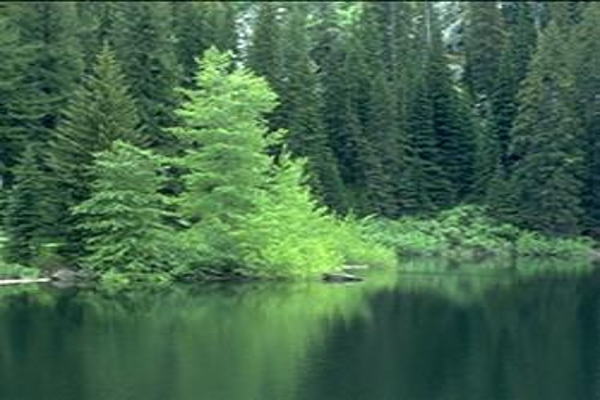



No Fire Detected


In [27]:
image = Image.open('Test_Data/Non_Fire/NF_459.jpg')
show_output(image)

## 12. Displaying Outputs together

In [28]:
test_ds = 'test'

In [29]:
all_display_data = ds.samples

In [32]:
def display_outputs():
  # shuffle(all_display_data)
  # display_data = all_display_data[0:12]
  plt.figure(figsize=(30,20))
  for i in range(8):

    image = Image.open('special_test_data/test'+str(i+9)+'.jpg')
    image.resize((250,250))
    inputs = feature_extractor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_idx = logits.softmax(1).argmax(-1).item()
    
    class_name = id2label[str(predicted_class_idx)]
    plt.subplot(3,4,i+1)
    ax = plt.gca()
    ax.set_title(
        class_name,
        size='xx-large',
        pad=5,
        loc='left',
        y=0,
        backgroundcolor='white'
    )
    ax.axis('off')
    plt.imshow(image)

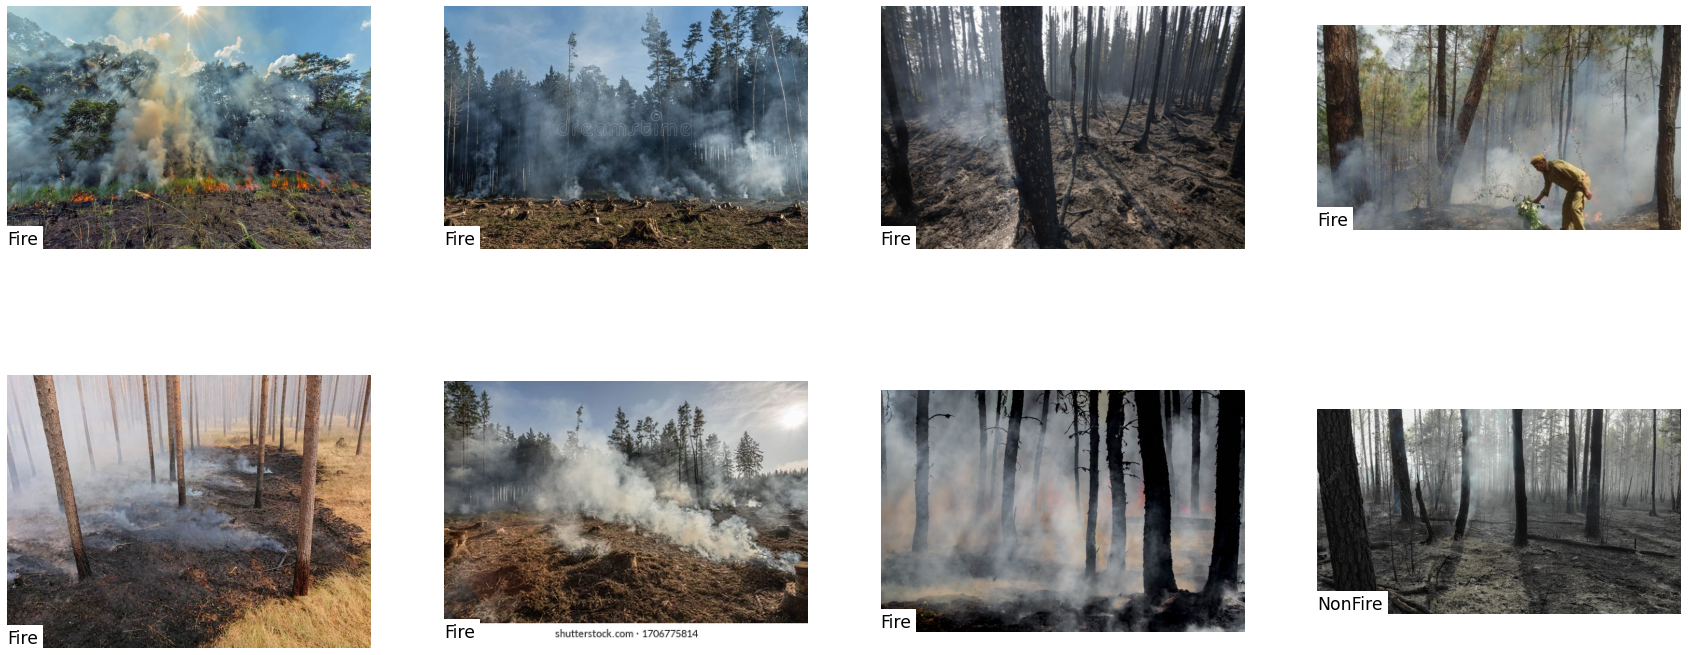

In [31]:
display_outputs()

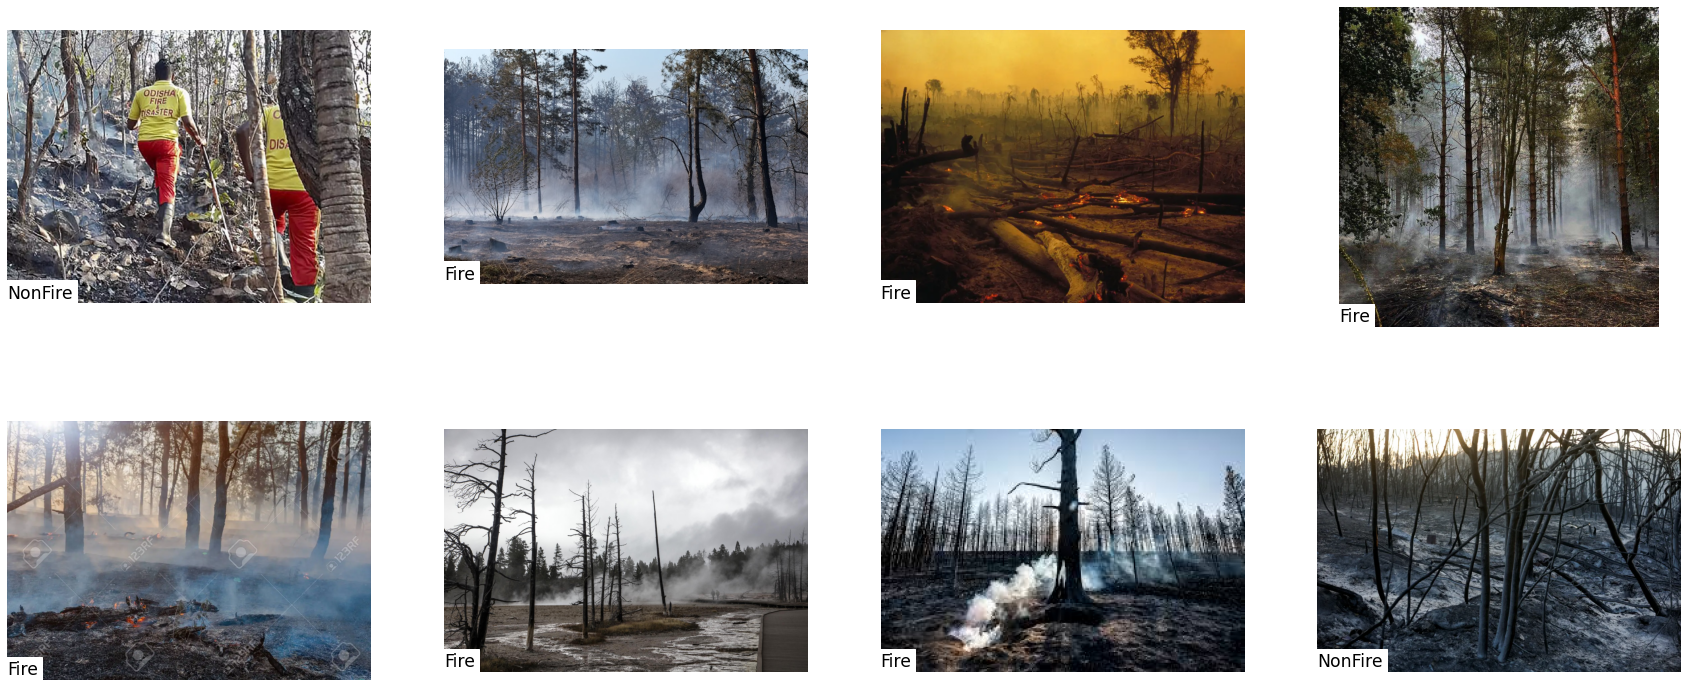

In [33]:
display_outputs()